#### Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import itertools
from scipy import stats
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'


#### Functions to load results and plot

In [2]:
def load_results(run, fix_unit, model_name, train_seq_part, part_name, an_part = 'sequential'):
    
    
    if an_part == 'sequential':
        
        if (part_name == "Human_Only") | (part_name == "Simulated_and_Human"):
            to_save_folder = '/scratch/gpfs/erussek/RNN_project/Sequential_Best_Param_Results_F'
        else:
            to_save_folder = '/scratch/gpfs/erussek/RNN_project/Sequential_Best_Param_Results'

        res_file_name = "{}_{}_{}_{}_run_{}.pickle".format(train_seq_part, part_name, model_name, fix_unit, run)
        full_file_name = os.path.join(to_save_folder, res_file_name)
        
    elif an_part == 'control':

        to_save_folder = '/scratch/gpfs/erussek/RNN_project/Control_Best_Param_Results'
        res_file_name = "{}_{}_run_{}.pickle".format(part_name, fix_unit, run)    
        full_file_name = os.path.join(to_save_folder, res_file_name)
        
    else: # Choice
        
        #to_save_folder = '/scratch/gpfs/erussek/RNN_project/Choice_Only_Best_Param_Results'
        to_save_folder = '/scratch/gpfs/erussek/RNN_project/Choice_Only_2P_Results'
        
        if part_name == 'Human_Only':
            to_save_folder = '/scratch/gpfs/erussek/RNN_project/Choice_Only_2P_Results_HO2'

        
        #res_file_name = "{}_{}_run_{}.pickle".format(train_seq_part, part_name, run)
        res_file_name = "{}_run_{}.pickle".format(part_name, run)

        full_file_name = os.path.join(to_save_folder, res_file_name)
    
    file = open(full_file_name, 'rb')
    res = pickle.load(file)
    
    return res

    
def load_results_all_runs(fix_unit, model_name, train_seq_part, part_name, n_runs = 50, start_run = 0, an_part = 'sequential'):
    
    results_list = []
    
    for run in range(start_run, n_runs):
        
        try:
            res = load_results(run, fix_unit, model_name, train_seq_part, part_name, an_part = an_part)

            results_list.append(res)
        except:
            continue
            #print('run')
        
    return results_list

def get_results_all_runs(fix_unit, model_name, train_seq_part, part_name, n_runs = 50, an_part = 'sequential', start_run = 0, which_res = 'r_sim_by_n_back'):
    
    results_list = load_results_all_runs(fix_unit, model_name, train_seq_part, part_name, n_runs = n_runs, an_part = an_part, start_run = start_run)
    
    r_by_n_back = np.array([res[which_res] for res in results_list])
    
    return r_by_n_back

def get_mn_results(fix_unit, model_name, train_seq_part, part_name, n_runs = 50, an_part = 'sequential', which_res = 'r_sim_by_n_back', start_run = 20):
    
    res_by_n_back = get_results_all_runs(fix_unit, model_name, train_seq_part, part_name, n_runs = n_runs, which_res = which_res, an_part = an_part, start_run = start_run)
    
    return np.mean(res_by_n_back, axis=0), 1.96*np.std(res_by_n_back, axis=0)/np.sqrt(len(res_by_n_back))

# get mses all runs...

def get_res_fixations_all_runs(fix_unit, model_name, train_seq_part, part_name, n_runs = 50, an_part = 'sequential', which_res = 'r_sim_by_n_back', which_n_back = 'n_items_human_by_n_back'):

    mse_by_n_back = get_results_all_runs(fix_unit, model_name, train_seq_part, part_name, start_run = 20, n_runs = n_runs, which_res = which_res, an_part = an_part)
    
    # ftm, compute this using human rather than sim data - should be the same...
    
    if (part_name == 'Simulated_Only') | (part_name == 'Simulated_Only_Pred_Human'):
        this_part_name = 'Human_Only'
    else:
        this_part_name = part_name
        
    n_items_by_n_back = get_results_all_runs(fix_unit, model_name, train_seq_part, this_part_name, start_run = 20, n_runs = n_runs, an_part = an_part, which_res = which_n_back)
    
    if (an_part == 'sequential') & (train_seq_part == 'Fixation_and_Choice'):
        
        mse_by_run = np.array([np.dot(mse_by_n_back[i][1:],n_items_by_n_back[i][1:])/np.sum(n_items_by_n_back[i][1:]) for i in range(len(mse_by_n_back))])
        
    else:
        
        mse_by_run = np.array([np.dot(mse_by_n_back[i][:-1],n_items_by_n_back[i][:-1])/np.sum(n_items_by_n_back[i][:-1]) for i in range(len(mse_by_n_back))])
        
    return mse_by_run

# types of models...
model_names = ['LSTM', 'GRU', 'Transformer']
part_names = ["Simulated_Only","Simulated_Only_Pred_Human", "Human_Only", "Simulated_and_Human"]
fix_unit_types = ['ID', 'all']
train_seq_parts = ['fix_and_choice']


In [12]:
#r_fix_seq_all_runs = get_res_fixations_all_runs(seq_fu, model_name, 'fix_and_choice', part_name, n_runs = 200, which_res = which_res)
def plot_fixatoin_and_choice_corr(part_name, model_name, seq_fu, control_fu, test_human, ax, labels = ['A', 'B'], include_title = True, include_xlabel = True, line_color = 'red'):
    
    if test_human:
        which_res = 'r_human_by_n_back'
        ylabel = 'Human Test Data Accuracy \n (Pearson Correlation Coefficient)'
    else:
        which_res = 'r_sim_by_n_back'
        ylabel = 'Simulated Test Data Accuracy \n (Pearson Correlation Coefficient)'

    # plot correlation over tiem-points for best control model and also best 
    these_tps = np.arange(-18,0,1)/10
    mn_r_by_n_back, sem_r = get_mn_results(seq_fu, model_name, 'fix_and_choice', part_name, n_runs = 200, which_res = which_res)
    ax[0].errorbar(these_tps,np.flip(mn_r_by_n_back[1:]), yerr = np.flip(sem_r[1:]), color = line_color, label = model_name)#, co
    
    r_fix_seq_all_runs = get_res_fixations_all_runs(seq_fu, model_name, 'fix_and_choice', part_name, n_runs = 200, an_part = 'sequential', which_res = which_res)

    #if len(control_fus) > 1:
    #    this_label = 'Best Controls (MLP)'
    #else:
    this_label = 'Best Control \n(MLP)'

    #for fu_idx, fu in enumerate(control_fus):
    fu = control_fu
    mn_r_by_n_back_c, sem_r_c = get_mn_results(fu, '', '', part_name, n_runs = 200, an_part = 'control', which_res = which_res)

    r_fix_control_all_runs = get_res_fixations_all_runs(fu, '', '', part_name, n_runs = 200, an_part = 'control', which_res = which_res)

    #if fu_idx == 0:
    ax[0].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = this_label, c = 'gray', ls = '--')
    #else:
    #    ax[0].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), c = 'gray', ls = '--')

    ax[0].legend()
    if include_xlabel:
        ax[0].set_xlabel('Time Point Relative to Choice (Seconds)')
        
    ax[0].set_ylabel(ylabel);
    
    if include_title:
        ax[0].set_title('Before Choice')
    
    # run a t test for seq
    
    print('Fixations Mean {} r: {}. Mean Control r: {}'.format(model_name, np.mean(r_fix_seq_all_runs), np.mean(r_fix_control_all_runs)))
    seq_t_res = stats.ttest_ind(r_fix_seq_all_runs, r_fix_control_all_runs)
    print('{} Seq. vs Control on Fixations T Test: '.format(model_name))
    print(seq_t_res)

    # plot choice only
    ax[1].errorbar(.25,np.flip(mn_r_by_n_back[0]), yerr = np.flip(sem_r[0]), label = 'Fixation and Choice \n(Transformer)', color = line_color, marker = 's')#, color = colors[0])

    if part_name == 'Simulated_and_Human':
        choice_part_name = 'Human_Only'
    else:
        choice_part_name = part_name
    
    mn_r_by_n_back_co, sem_r_co = get_mn_results(seq_fu, model_name, 'choice_only', choice_part_name, n_runs = 400, an_part = 'Choice Only', which_res = which_res)
    ax[1].errorbar(.75, mn_r_by_n_back_co, yerr = sem_r_co, label = 'Choice Only', marker = 's')#, color = colors[0])
    #ax[1].bar(.75, mn_r_by_n_back_co)#, color = colors[0])

    ax[1].set_xlim(0,1)
    ax[1].set_ylabel(ylabel);

    if include_xlabel:
        ax[1].set_xticks([.25,.75])
        ax[1].set_xticklabels(['Fixations and \n Choice ({})'.format(model_name),'Choice Only'], rotation = 45)
    else:
        ax[1].set_xticks([])
        ax[1].set_xticklabels([])
    
    if include_title:
        ax[1].set_title('After Choice')
    
    # run a t-test for choice... 
    r_by_n_back_seq = get_results_all_runs(seq_fu, model_name, 'fix_and_choice', part_name, n_runs = 200, which_res = which_res)
    seq_rs_choice = r_by_n_back_seq[:,0]
    
    mlp_rs_choice = get_results_all_runs(seq_fu, '', 'choice_only', part_name, n_runs = 200, an_part = 'Choice Only', which_res = 'r_human_by_n_back')
    
    choice_t_res = stats.ttest_ind(seq_rs_choice, mlp_rs_choice, equal_var = True)
    
    print('Choice Mean {} r: {}. Mean MLP r: {}'.format(model_name, np.mean(seq_rs_choice), np.mean(mlp_rs_choice)))
    print('{} Seq. vs MLP on Choice T Test: '.format(model_name))
    print(choice_t_res)

    #for i in range(2):
    #    ax[i].set_title(labels[i], loc = 'Left', fontsize = 'medium', weight = 'bold')
        



## Figure 1: Performance on training simulated, testing simulated data LSTM model

Fixations Mean LSTM r: 0.32820364551434766. Mean Control r: 0.2790475636645014
LSTM Seq. vs Control on Fixations T Test: 
Ttest_indResult(statistic=22.070571841471306, pvalue=9.354807554739915e-69)
Choice Mean LSTM r: 0.60100819023693. Mean MLP r: 0.48055906069463716
LSTM Seq. vs MLP on Choice T Test: 
Ttest_indResult(statistic=91.98484179567771, pvalue=8.767985702330313e-262)


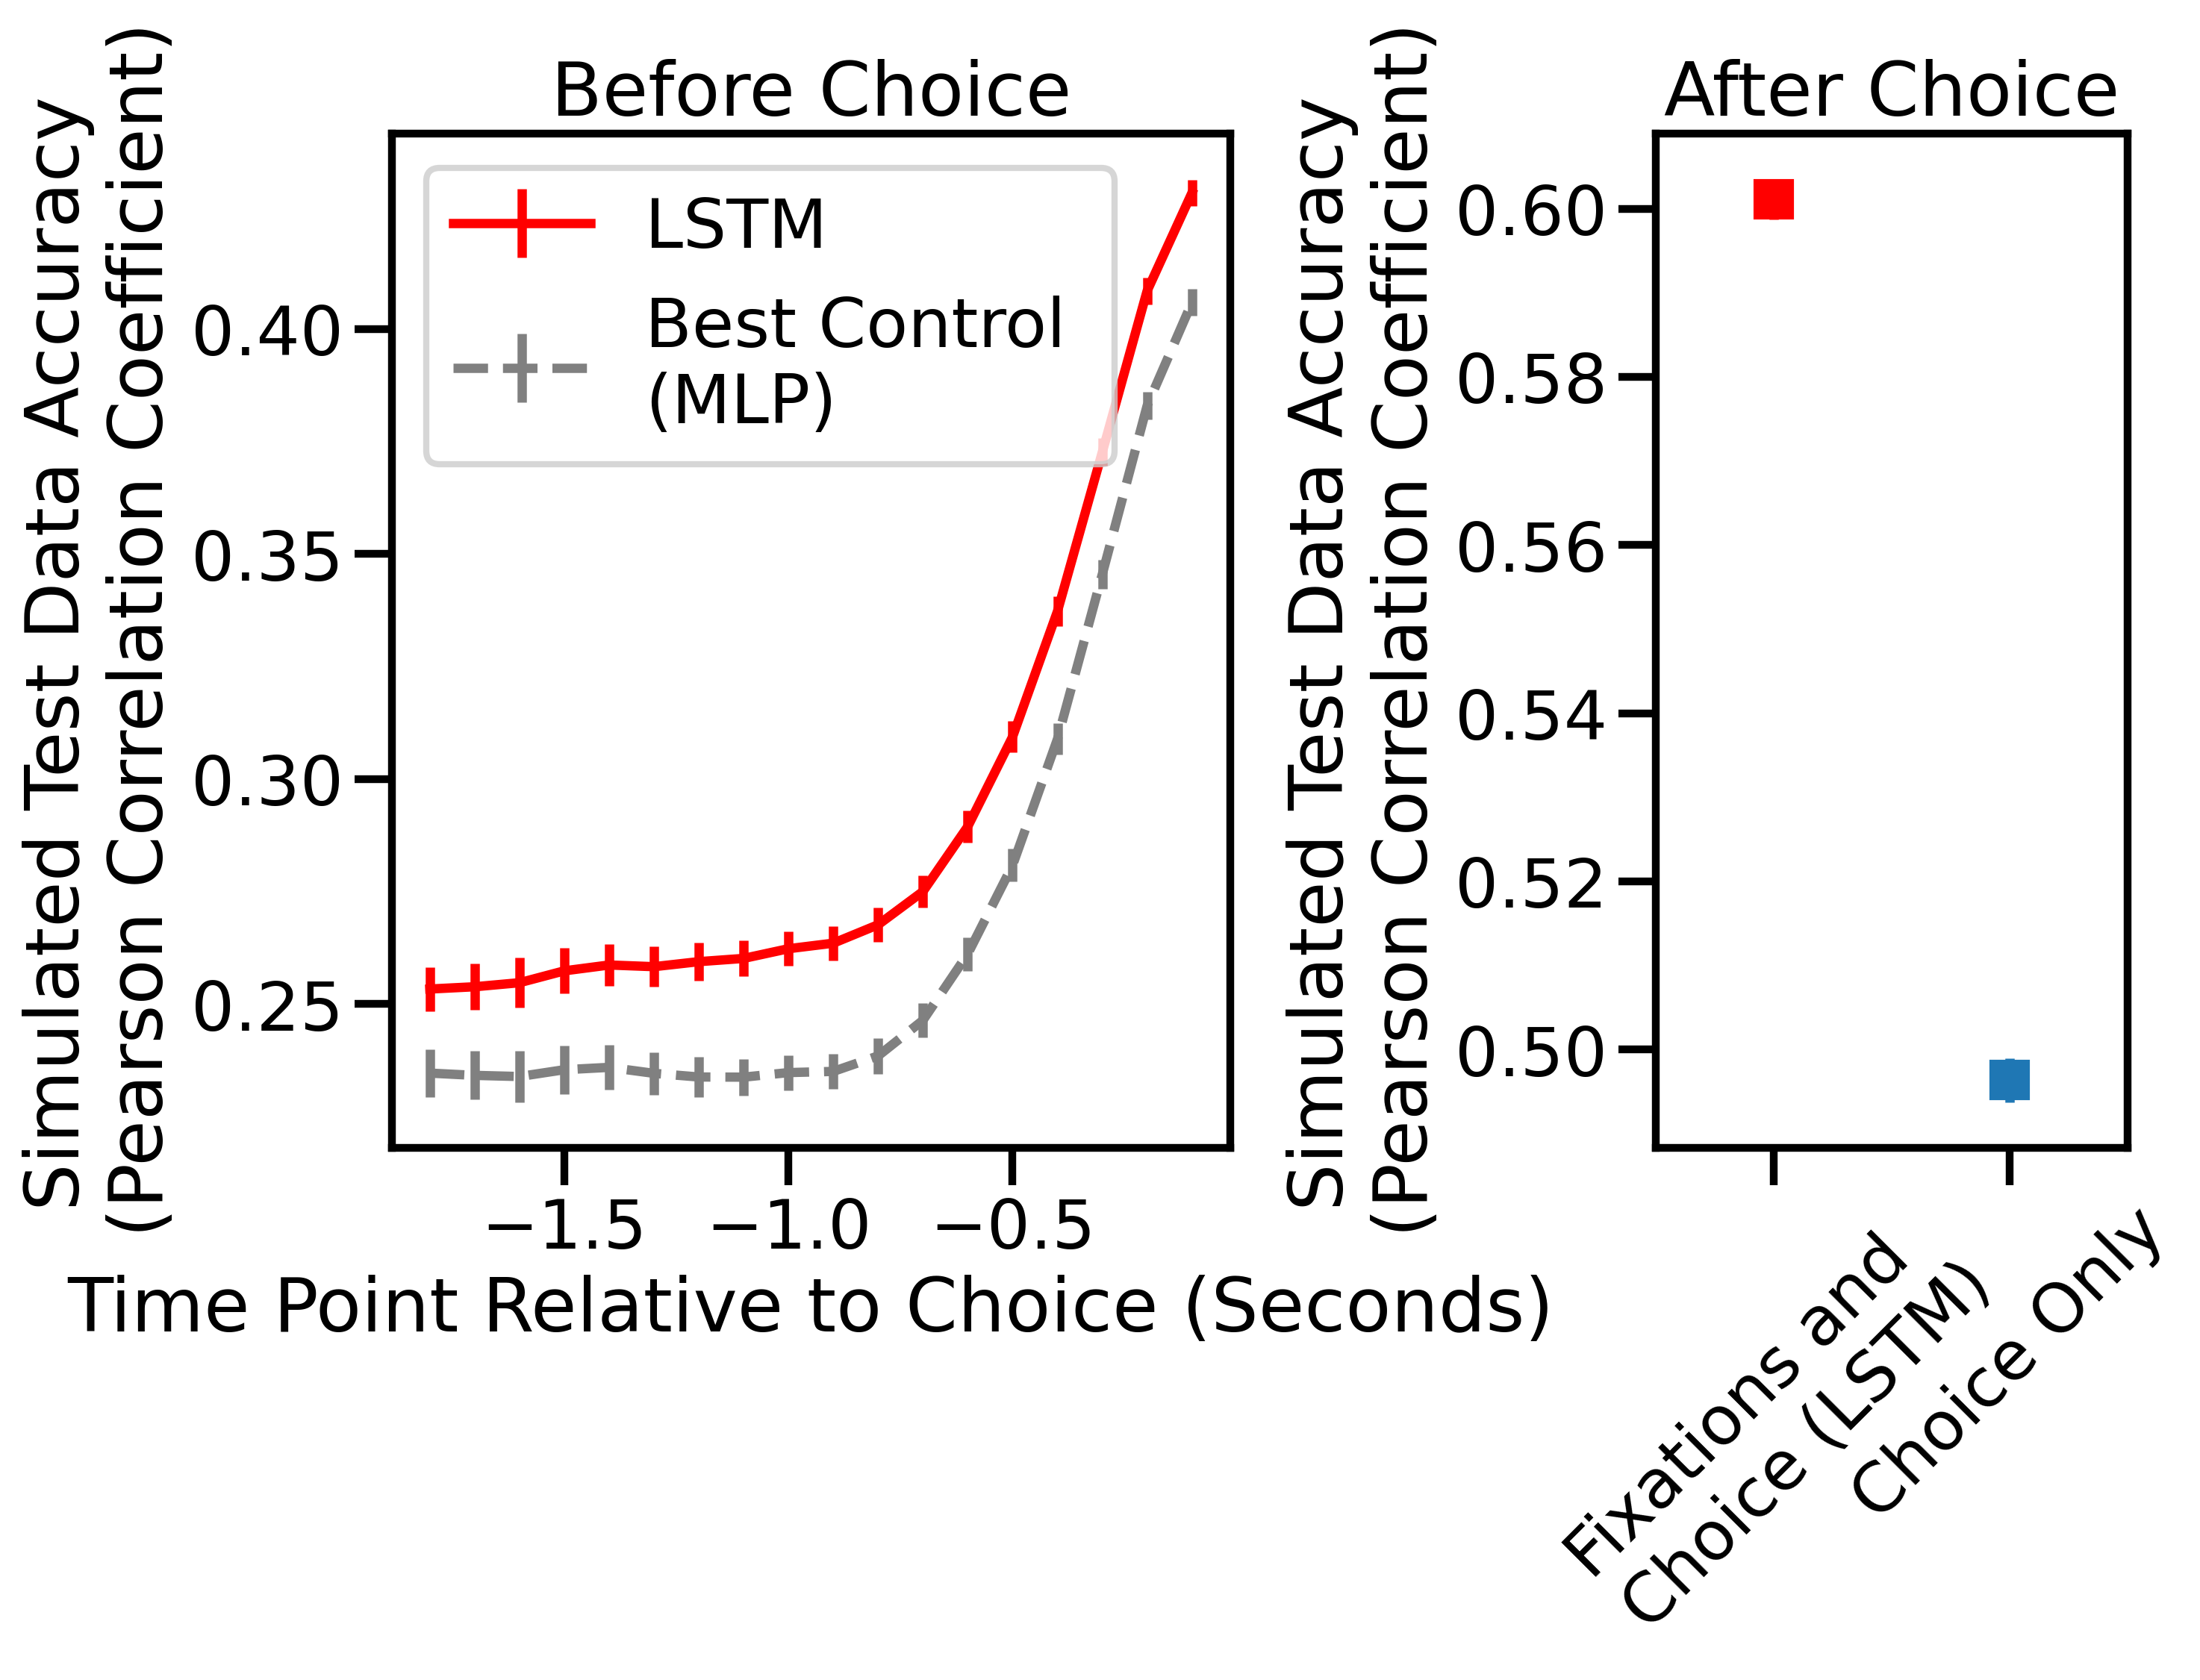

In [13]:
sns.set_context("poster")

part_name = 'Simulated_Only'
model_name = 'LSTM'
seq_fu = 'ID' # all is messed up
control_fus = 'all'
test_human = False

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), dpi = 300,
                       gridspec_kw={
                           'width_ratios': [4, 2.25],
                       'wspace': .65}, sharey = False)

plot_fixatoin_and_choice_corr(part_name, model_name, seq_fu, control_fus, test_human, ax)
#plt.savefig("Paper_Figs_F/Train_Sim_Test_Sim_LSTM.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("Poster_Figs/Train_Sim_Test_Sim_LSTM.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)



## Supp Figs: Performance on training simulated, testing simulated data GRU and Transformer Models


Fixations Mean GRU r: 0.3222817488787586. Mean Control r: 0.2790475636645014
GRU Seq. vs Control on Fixations T Test: 
Ttest_indResult(statistic=19.319377310760046, pvalue=1.7704802423055157e-57)
Choice Mean GRU r: 0.5971976104243235. Mean MLP r: 0.48055906069463716
GRU Seq. vs MLP on Choice T Test: 
Ttest_indResult(statistic=89.74369677524983, pvalue=6.837446977706837e-258)
Fixations Mean Transformer r: 0.3134029805054172. Mean Control r: 0.2790475636645014
Transformer Seq. vs Control on Fixations T Test: 
Ttest_indResult(statistic=15.365823408448088, pvalue=2.794780987568806e-41)
Choice Mean Transformer r: 0.5862978724727171. Mean MLP r: 0.48055906069463716
Transformer Seq. vs MLP on Choice T Test: 
Ttest_indResult(statistic=77.84461812816915, pvalue=1.2537970809304119e-235)


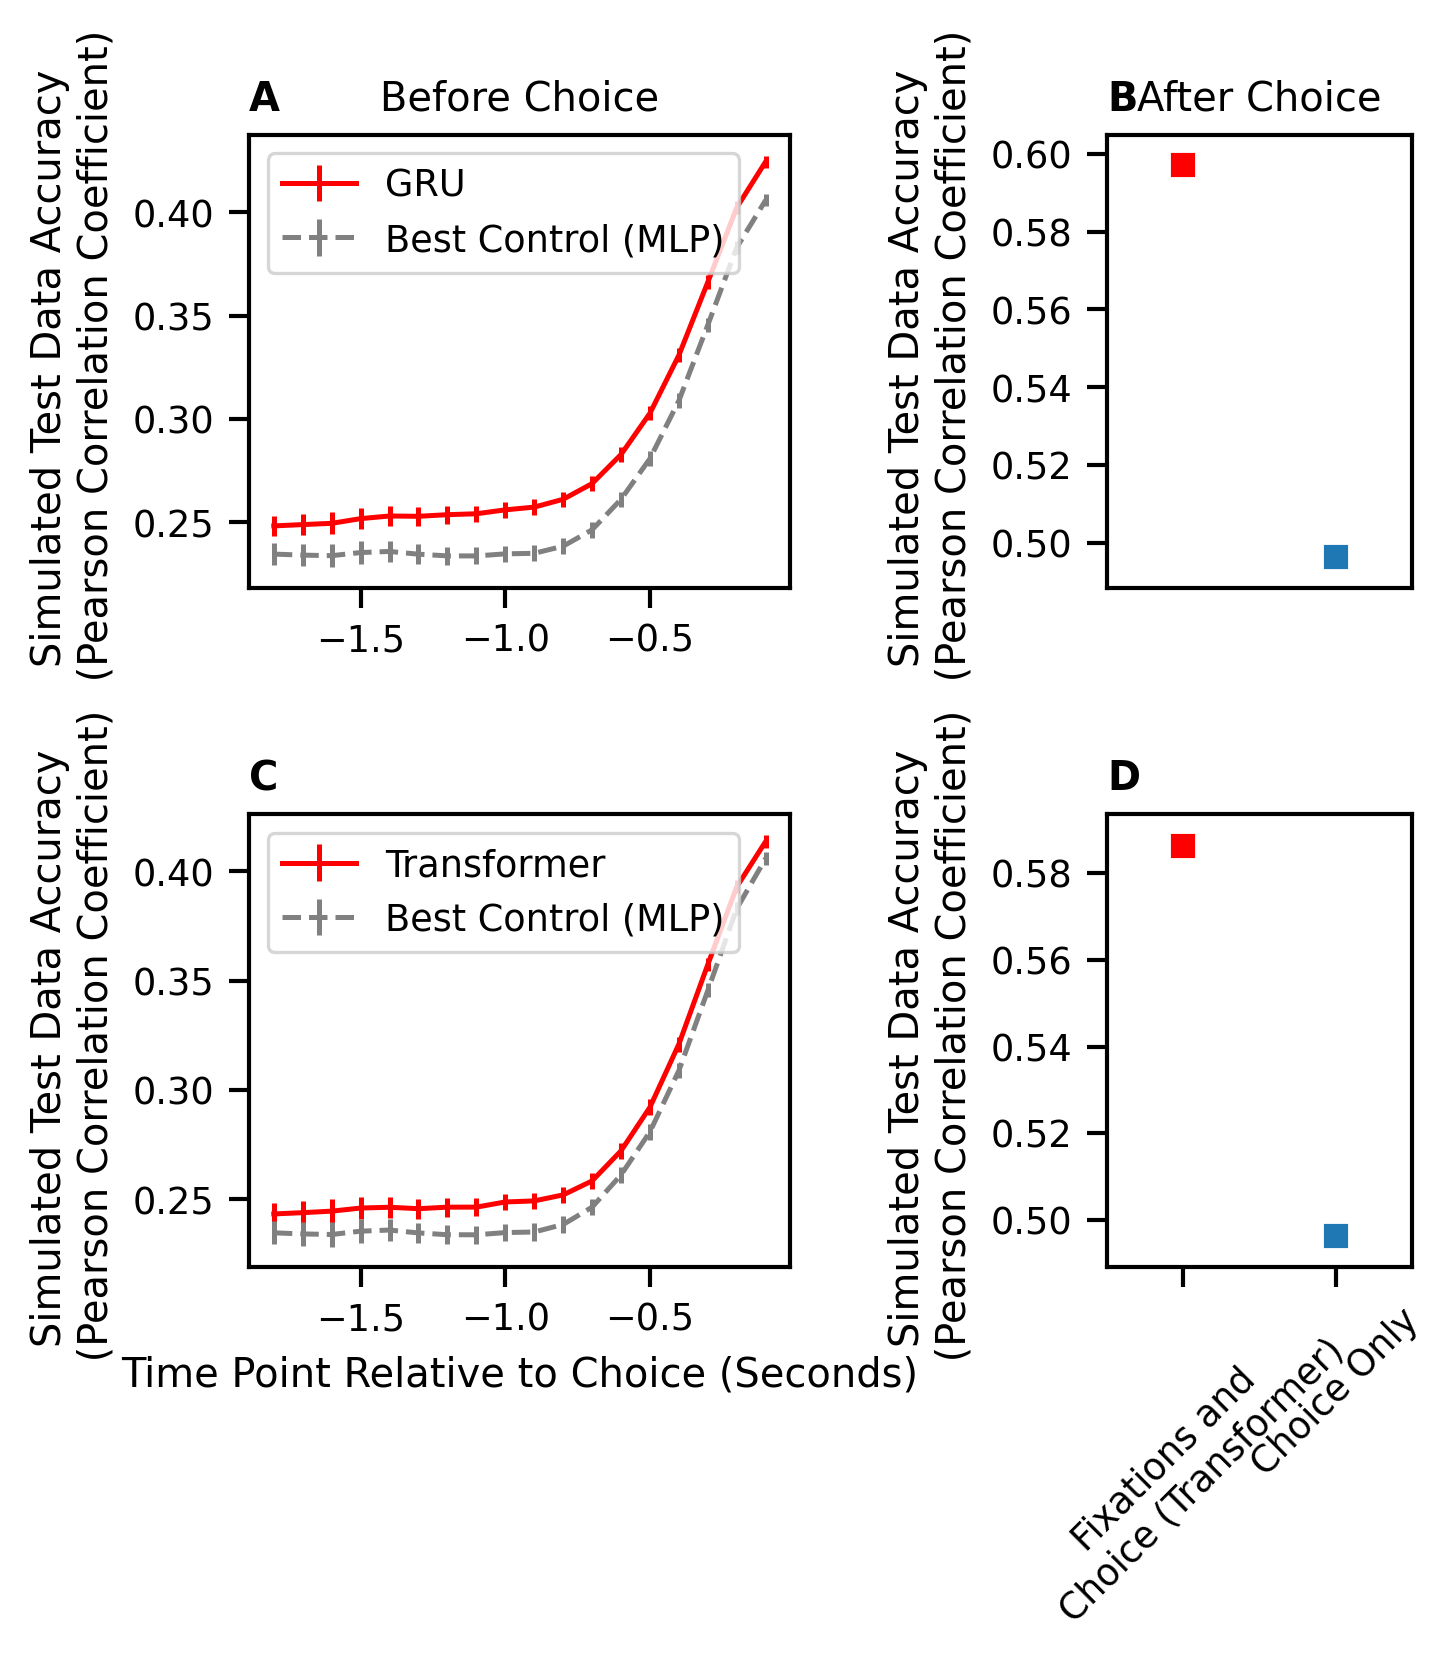

In [5]:
sns.set_context("paper")

# plot 
part_name = 'Simulated_Only'
seq_fu = 'ID' # all is messed up
control_fus = 'all'
test_human = False

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), dpi = 300,
                       gridspec_kw={
                        'width_ratios': [4, 2.25],
                       'wspace': .75,
                       'hspace': .5}, sharey = False)

plot_fixatoin_and_choice_corr(part_name, 'GRU', seq_fu, control_fus, test_human, [ax[0,0], ax[0,1]], include_xlabel = False)
plot_fixatoin_and_choice_corr(part_name, 'Transformer', seq_fu, control_fus, test_human, [ax[1,0], ax[1,1]], include_title = False, labels = ['C', 'D'])

plt.savefig("Paper_Figs_F/Train_Sim_Test_Sim_Other.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("Paper_Figs_F/Train_Sim_Test_Sim_Other.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


## Figure 3: Performance on training Human, testing Human data LSTM model

Fixations Mean LSTM r: 0.15548333522622704. Mean Control r: 0.10462208047382768
LSTM Seq. vs Control on Fixations T Test: 
Ttest_indResult(statistic=37.25721812791831, pvalue=3.0823790680916824e-125)
Choice Mean LSTM r: 0.49053601314233974. Mean MLP r: 0.4805396414252081
LSTM Seq. vs MLP on Choice T Test: 
Ttest_indResult(statistic=12.529520202911955, pvalue=2.0252496559754353e-30)


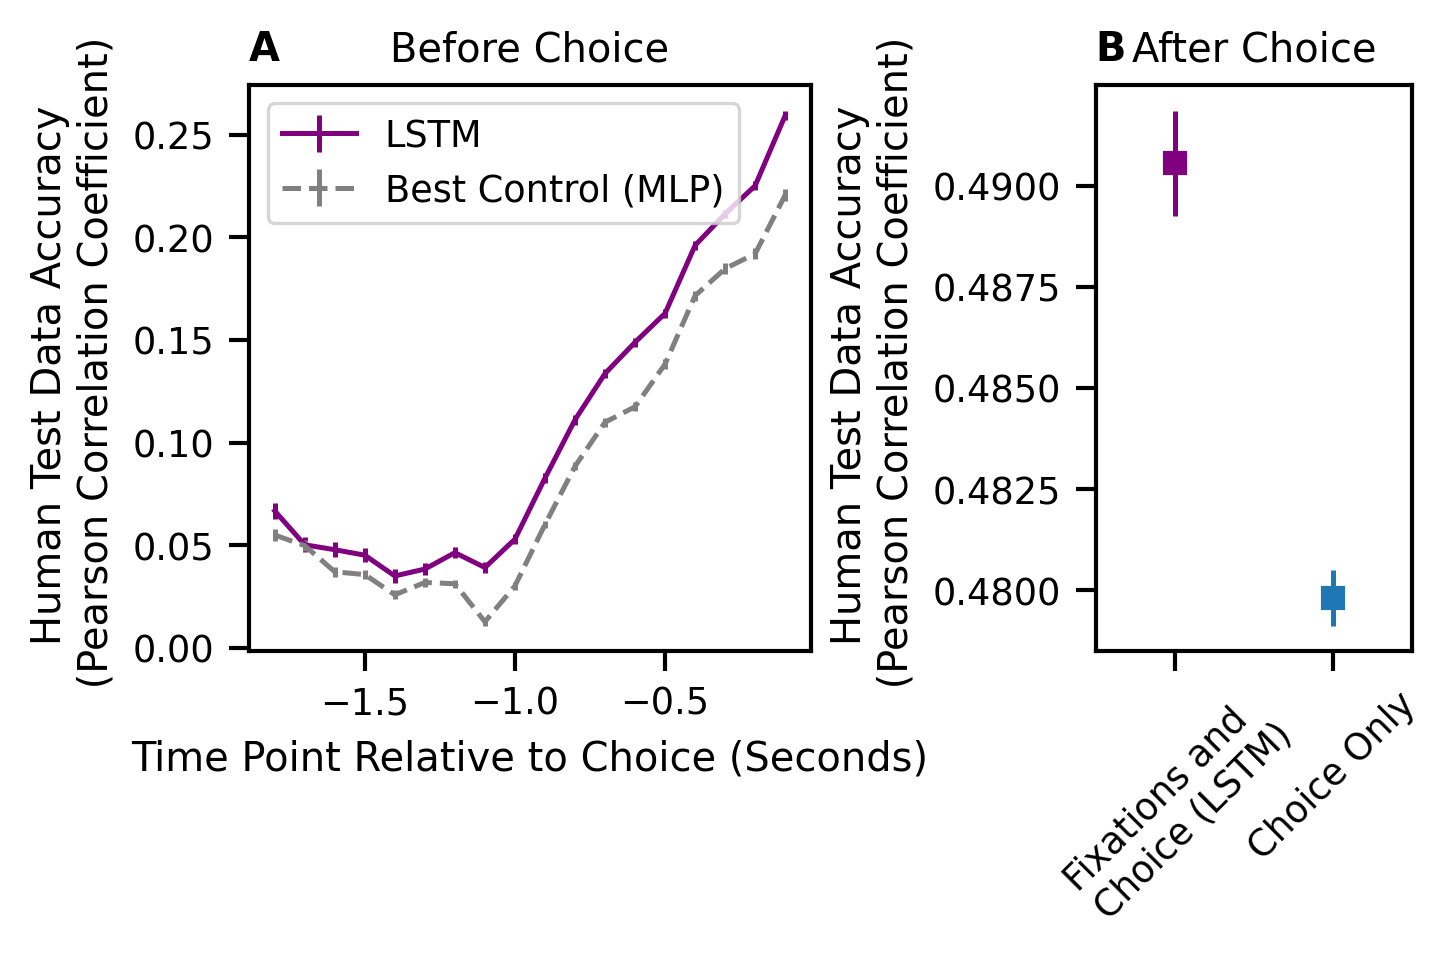

In [6]:
sns.set_context("paper")

part_name = 'Simulated_and_Human'
model_name = 'LSTM'
seq_fu = 'ID' # all is messed up
control_fus = 'all'
test_human = True

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.5), dpi = 300,
                       gridspec_kw={
                           'width_ratios': [4, 2.25],
                       'wspace': .65}, sharey = False)

plot_fixatoin_and_choice_corr(part_name, model_name, seq_fu, control_fus, test_human, ax, line_color = 'purple')

plt.savefig("Paper_Figs_F/Train_Sim_and_Human_Test_Human_LSTM.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("Paper_Figs_F/Train_Sim_and_Human_Test_Human_LSTM.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


## Supp Figs: Performance on training simulated and Human testing Human data GRU and Transformer Models

Fixations Mean GRU r: 0.15818070246073695. Mean Control r: 0.10462208047382768
GRU Seq. vs Control on Fixations T Test: 
Ttest_indResult(statistic=42.33403762584406, pvalue=1.978816353366864e-141)
Choice Mean GRU r: 0.4903983234023185. Mean MLP r: 0.4805396414252081
GRU Seq. vs MLP on Choice T Test: 
Ttest_indResult(statistic=12.516409022590802, pvalue=2.2771271228028618e-30)
Fixations Mean Transformer r: 0.1544541771635484. Mean Control r: 0.10462208047382768
Transformer Seq. vs Control on Fixations T Test: 
Ttest_indResult(statistic=38.713759241927626, pvalue=5.1156530040225904e-130)
Choice Mean Transformer r: 0.5031374545438275. Mean MLP r: 0.4805396414252081
Transformer Seq. vs MLP on Choice T Test: 
Ttest_indResult(statistic=31.831684487606935, pvalue=1.2618399484784582e-109)


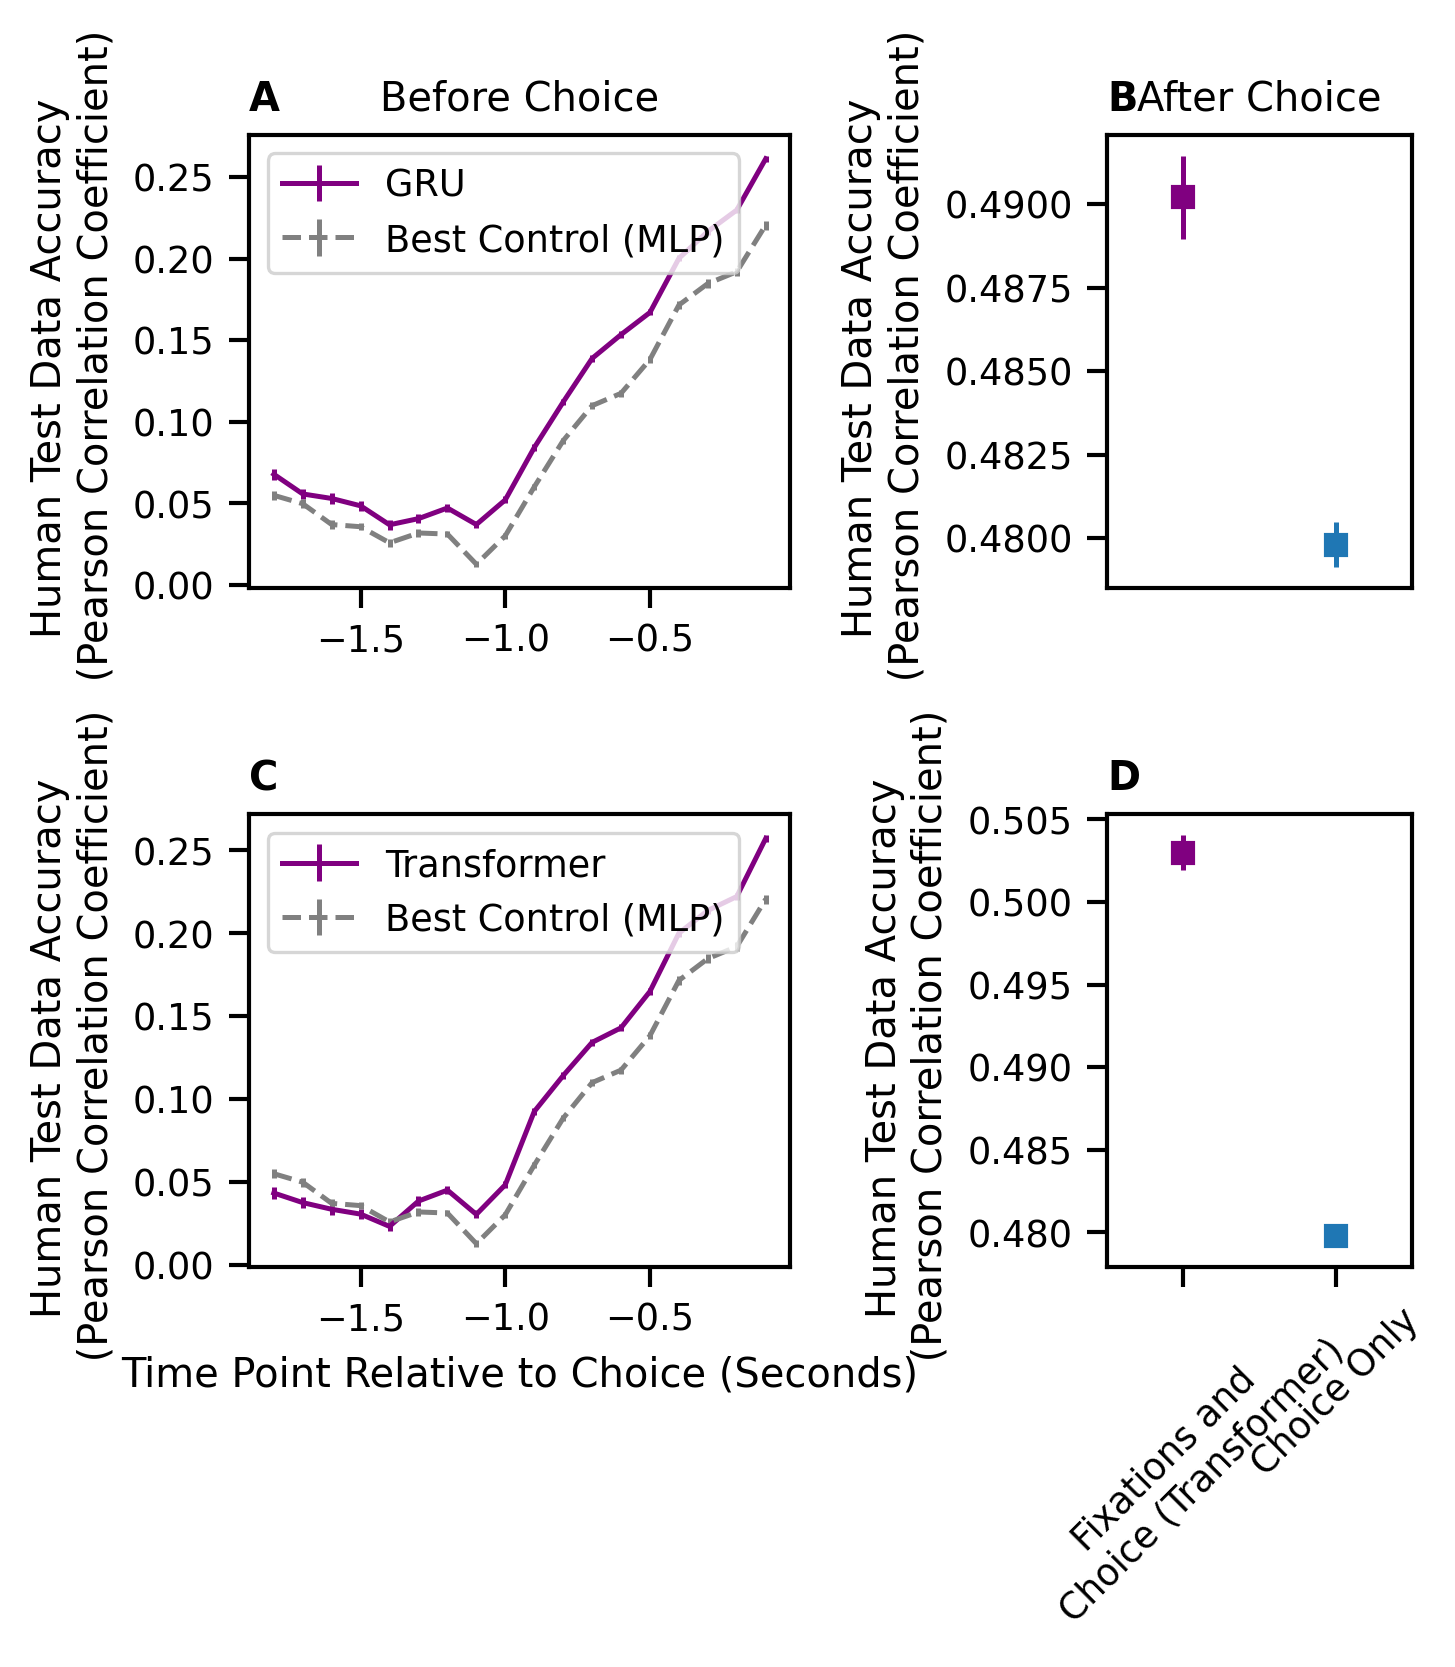

In [7]:
sns.set_context("paper")

# plot 
part_name = 'Simulated_and_Human'
seq_fu = 'ID' # all is messed up
control_fus = 'all'
test_human = True

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), dpi = 300,
                       gridspec_kw={
                        'width_ratios': [4, 2.25],
                       'wspace': .75,
                       'hspace': .5}, sharey = False)

plot_fixatoin_and_choice_corr(part_name, 'GRU', seq_fu, control_fus, test_human, [ax[0,0], ax[0,1]], include_xlabel = False, line_color = 'purple')
plot_fixatoin_and_choice_corr(part_name, 'Transformer', seq_fu, control_fus, test_human, [ax[1,0], ax[1,1]], include_title = False, labels = ['C', 'D'], line_color = 'purple')

plt.savefig("Paper_Figs_F/Train_Sim_and_Human_Test_Human_Other.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("Paper_Figs_F/Train_Sim_and_Human_Test_Human_Other.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


In [8]:
def plot_compare_traindata(model_name, ax, labels = ['A', 'B']):

    colors = ['r', 'b', 'purple']

    choice_xs = [.25, .5, .75]

    label_partnames = ['Simulated', 'Human', 'Simulated and\nHuman']
    
    r_fix_by_runs = {}
    r_choice_by_runs = {}
    
    print('\n{} Results: \n'.format(model_name))
    
    for part_name_idx, part_name, in enumerate(part_names[1::]):
        
        #print(part_name)

        r_fix_by_runs[part_name] = get_res_fixations_all_runs('ID', model_name, 'fix_and_choice', part_name, n_runs = 200, an_part = 'sequential', which_res = 'r_human_by_n_back')
            # run a t-test for choice... 
        r_by_n_back_seq = get_results_all_runs('ID', model_name, 'fix_and_choice', part_name, n_runs = 200, which_res = 'r_human_by_n_back')
        r_choice_by_runs[part_name] = r_by_n_back_seq[:,0]
        
        
        print('\nMean r fix {}: {}'.format(part_name, np.mean(r_fix_by_runs[part_name])))
        print('Mean r Choice {}: {}'.format(part_name, np.mean(r_choice_by_runs[part_name])))

        # print(r_fix_seq_all_runs)
        
        mn_r_by_n_back, sem_r = get_mn_results('ID', model_name, 'fix_and_choice', part_name, n_runs = 200, which_res = 'r_human_by_n_back')
        these_tps = np.arange(-18,1,1)/10
        ax[0].errorbar(these_tps[:-1],np.flip(mn_r_by_n_back[1:]), yerr=np.flip(sem_r[1:]), c = colors[part_name_idx], label = label_partnames[part_name_idx])

        ax[1].errorbar(choice_xs[part_name_idx],mn_r_by_n_back[0], yerr = sem_r[0], c = colors[part_name_idx], marker = 's', label = label_partnames[part_name_idx])#, color = colors[0])

    ax[0].set_xlabel('Time Point Relative to Choice (Seconds)')
    ax[0].set_title('Before Choice')
    
    print('Fixation T Tests')
    print('\nT Test {} vs {}'.format(part_names[1], part_names[2]))
    print(stats.ttest_ind(r_fix_by_runs[part_names[1]], r_fix_by_runs[part_names[2]]))
    
    print('\nT Test {} vs {}'.format(part_names[1], part_names[3]))
    print(stats.ttest_ind(r_fix_by_runs[part_names[1]], r_fix_by_runs[part_names[3]]))
    
    print('\nT Test {} vs {}'.format(part_names[2], part_names[3]))
    print(stats.ttest_ind(r_fix_by_runs[part_names[2]], r_fix_by_runs[part_names[3]]))
    
    print('\nChoice T Tests')
    print('\nT Test {} vs {}'.format(part_names[1], part_names[2]))
    print(stats.ttest_ind(r_choice_by_runs[part_names[1]], r_choice_by_runs[part_names[2]]))
    
    print('\nT Test {} vs {}'.format(part_names[1], part_names[3]))
    print(stats.ttest_ind(r_choice_by_runs[part_names[1]], r_choice_by_runs[part_names[3]]))
    
    print('\nT Test {} vs {}'.format(part_names[2], part_names[3]))
    print(stats.ttest_ind(r_choice_by_runs[part_names[2]], r_choice_by_runs[part_names[3]]))
    
    ax[1].set_title('After Choice')
    ax[1].set_xticks([])
    ax[1].set_xticklabels([])

    for idx in range(2):
        ax[idx].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient')

    ax[1].legend(title = '{} Training Data'.format(model_name), loc = (1.05,.4))

    for i in range(2):
        ax[i].set_title(labels[i], loc = 'Left', fontsize = 'medium', weight = 'bold')
        
    


LSTM Results: 


Mean r fix Simulated_Only_Pred_Human: 0.1280798216617458
Mean r Choice Simulated_Only_Pred_Human: 0.47509984705890934

Mean r fix Human_Only: 0.13152059277730885
Mean r Choice Human_Only: 0.4769702164297568

Mean r fix Simulated_and_Human: 0.15548333522622704
Mean r Choice Simulated_and_Human: 0.49053601314233974
Fixation T Tests

T Test Simulated_Only_Pred_Human vs Human_Only
Ttest_indResult(statistic=-2.118393054991551, pvalue=0.034830244222639195)

T Test Simulated_Only_Pred_Human vs Simulated_and_Human
Ttest_indResult(statistic=-18.048638671933798, pvalue=3.0369729142965463e-52)

T Test Human_Only vs Simulated_and_Human
Ttest_indResult(statistic=-15.915891089787147, pvalue=1.6513948396351027e-43)

Choice T Tests

T Test Simulated_Only_Pred_Human vs Human_Only
Ttest_indResult(statistic=-2.2769933947225045, pvalue=0.02331664929954919)

T Test Simulated_Only_Pred_Human vs Simulated_and_Human
Ttest_indResult(statistic=-18.20581106937565, pvalue=2.5831908413154338e-54)

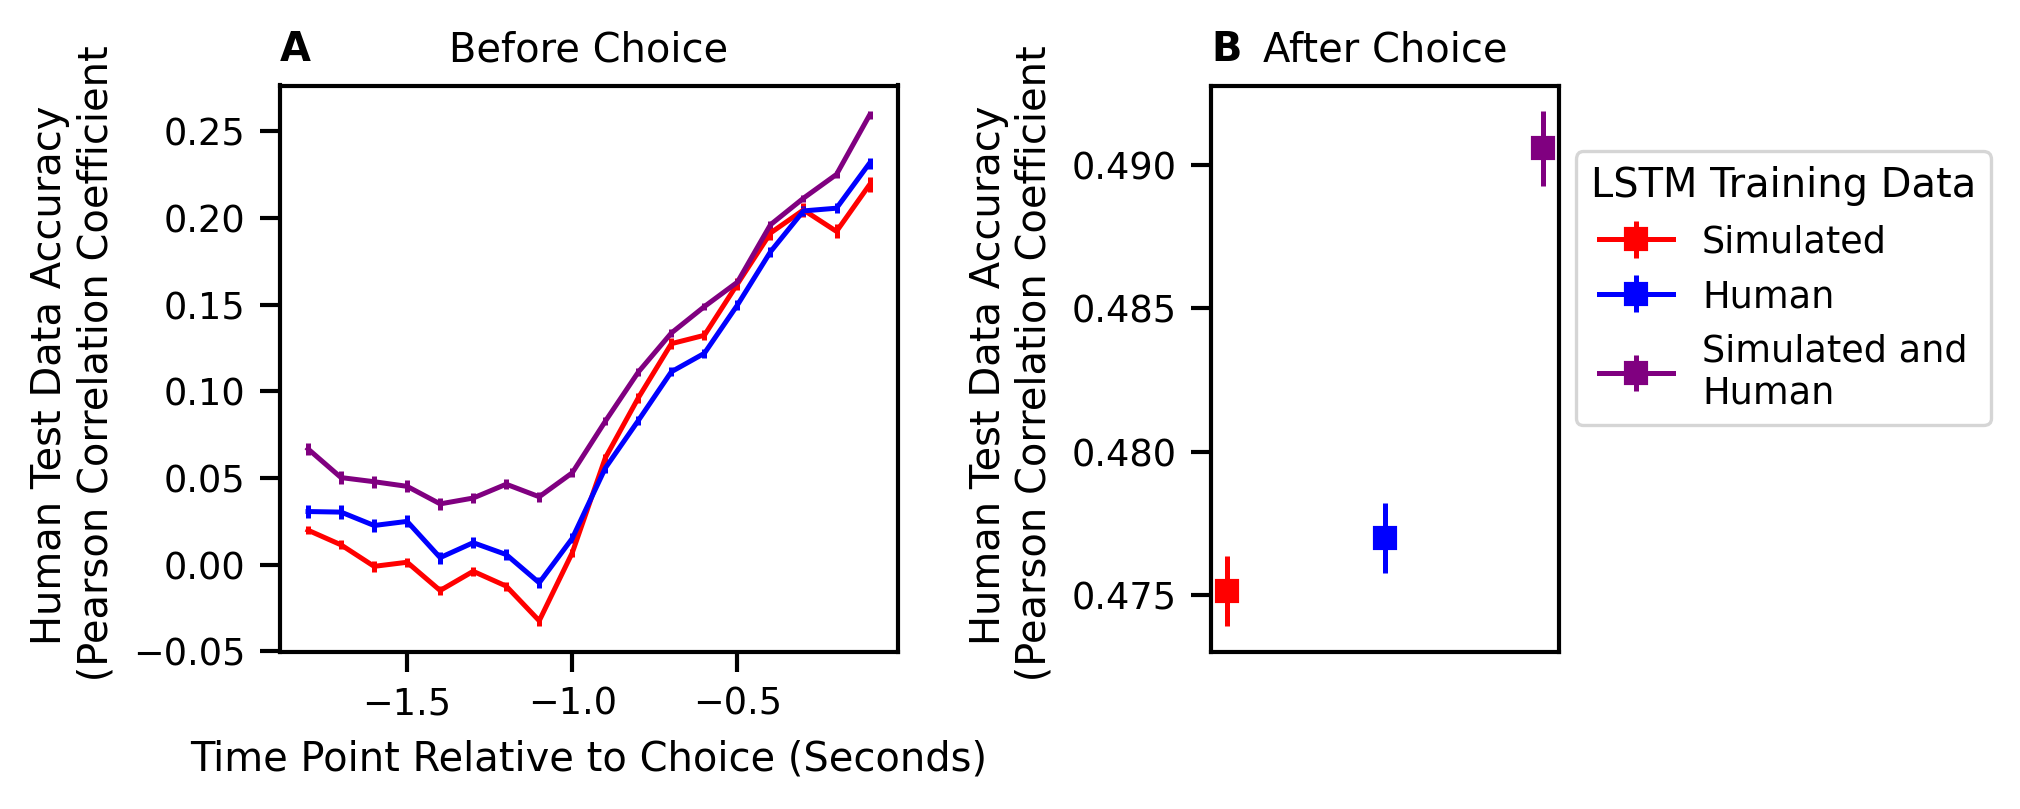

In [9]:
sns.set_context("paper")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5.5, 2.5), dpi = 300,
                       gridspec_kw={
                        'width_ratios': [4, 2.25],
                       'wspace': .65}, sharey = False)

plot_compare_traindata('LSTM', ax, labels = ['A', 'B'])
plt.savefig("Paper_Figs_F/Compare_Train_Data_LSTM.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=.01)
plt.savefig("Paper_Figs_F/Compare_Train_Data_LSTM.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=.01)



GRU Results: 


Mean r fix Simulated_Only_Pred_Human: 0.13908503699419084
Mean r Choice Simulated_Only_Pred_Human: 0.4860918318884124

Mean r fix Human_Only: 0.1265815843693733
Mean r Choice Human_Only: 0.47500646685092834

Mean r fix Simulated_and_Human: 0.15818070246073695
Mean r Choice Simulated_and_Human: 0.4903983234023185
Fixation T Tests

T Test Simulated_Only_Pred_Human vs Human_Only
Ttest_indResult(statistic=11.117254687353073, pvalue=7.275554859661676e-25)

T Test Simulated_Only_Pred_Human vs Simulated_and_Human
Ttest_indResult(statistic=-15.921969851188313, pvalue=1.5600837081023955e-43)

T Test Human_Only vs Simulated_and_Human
Ttest_indResult(statistic=-28.44077339392638, pvalue=7.100146852129847e-94)

Choice T Tests

T Test Simulated_Only_Pred_Human vs Human_Only
Ttest_indResult(statistic=13.895437047904393, pvalue=4.5827781261776755e-36)

T Test Simulated_Only_Pred_Human vs Simulated_and_Human
Ttest_indResult(statistic=-5.03382679621332, pvalue=7.298089100685125e-07)

T

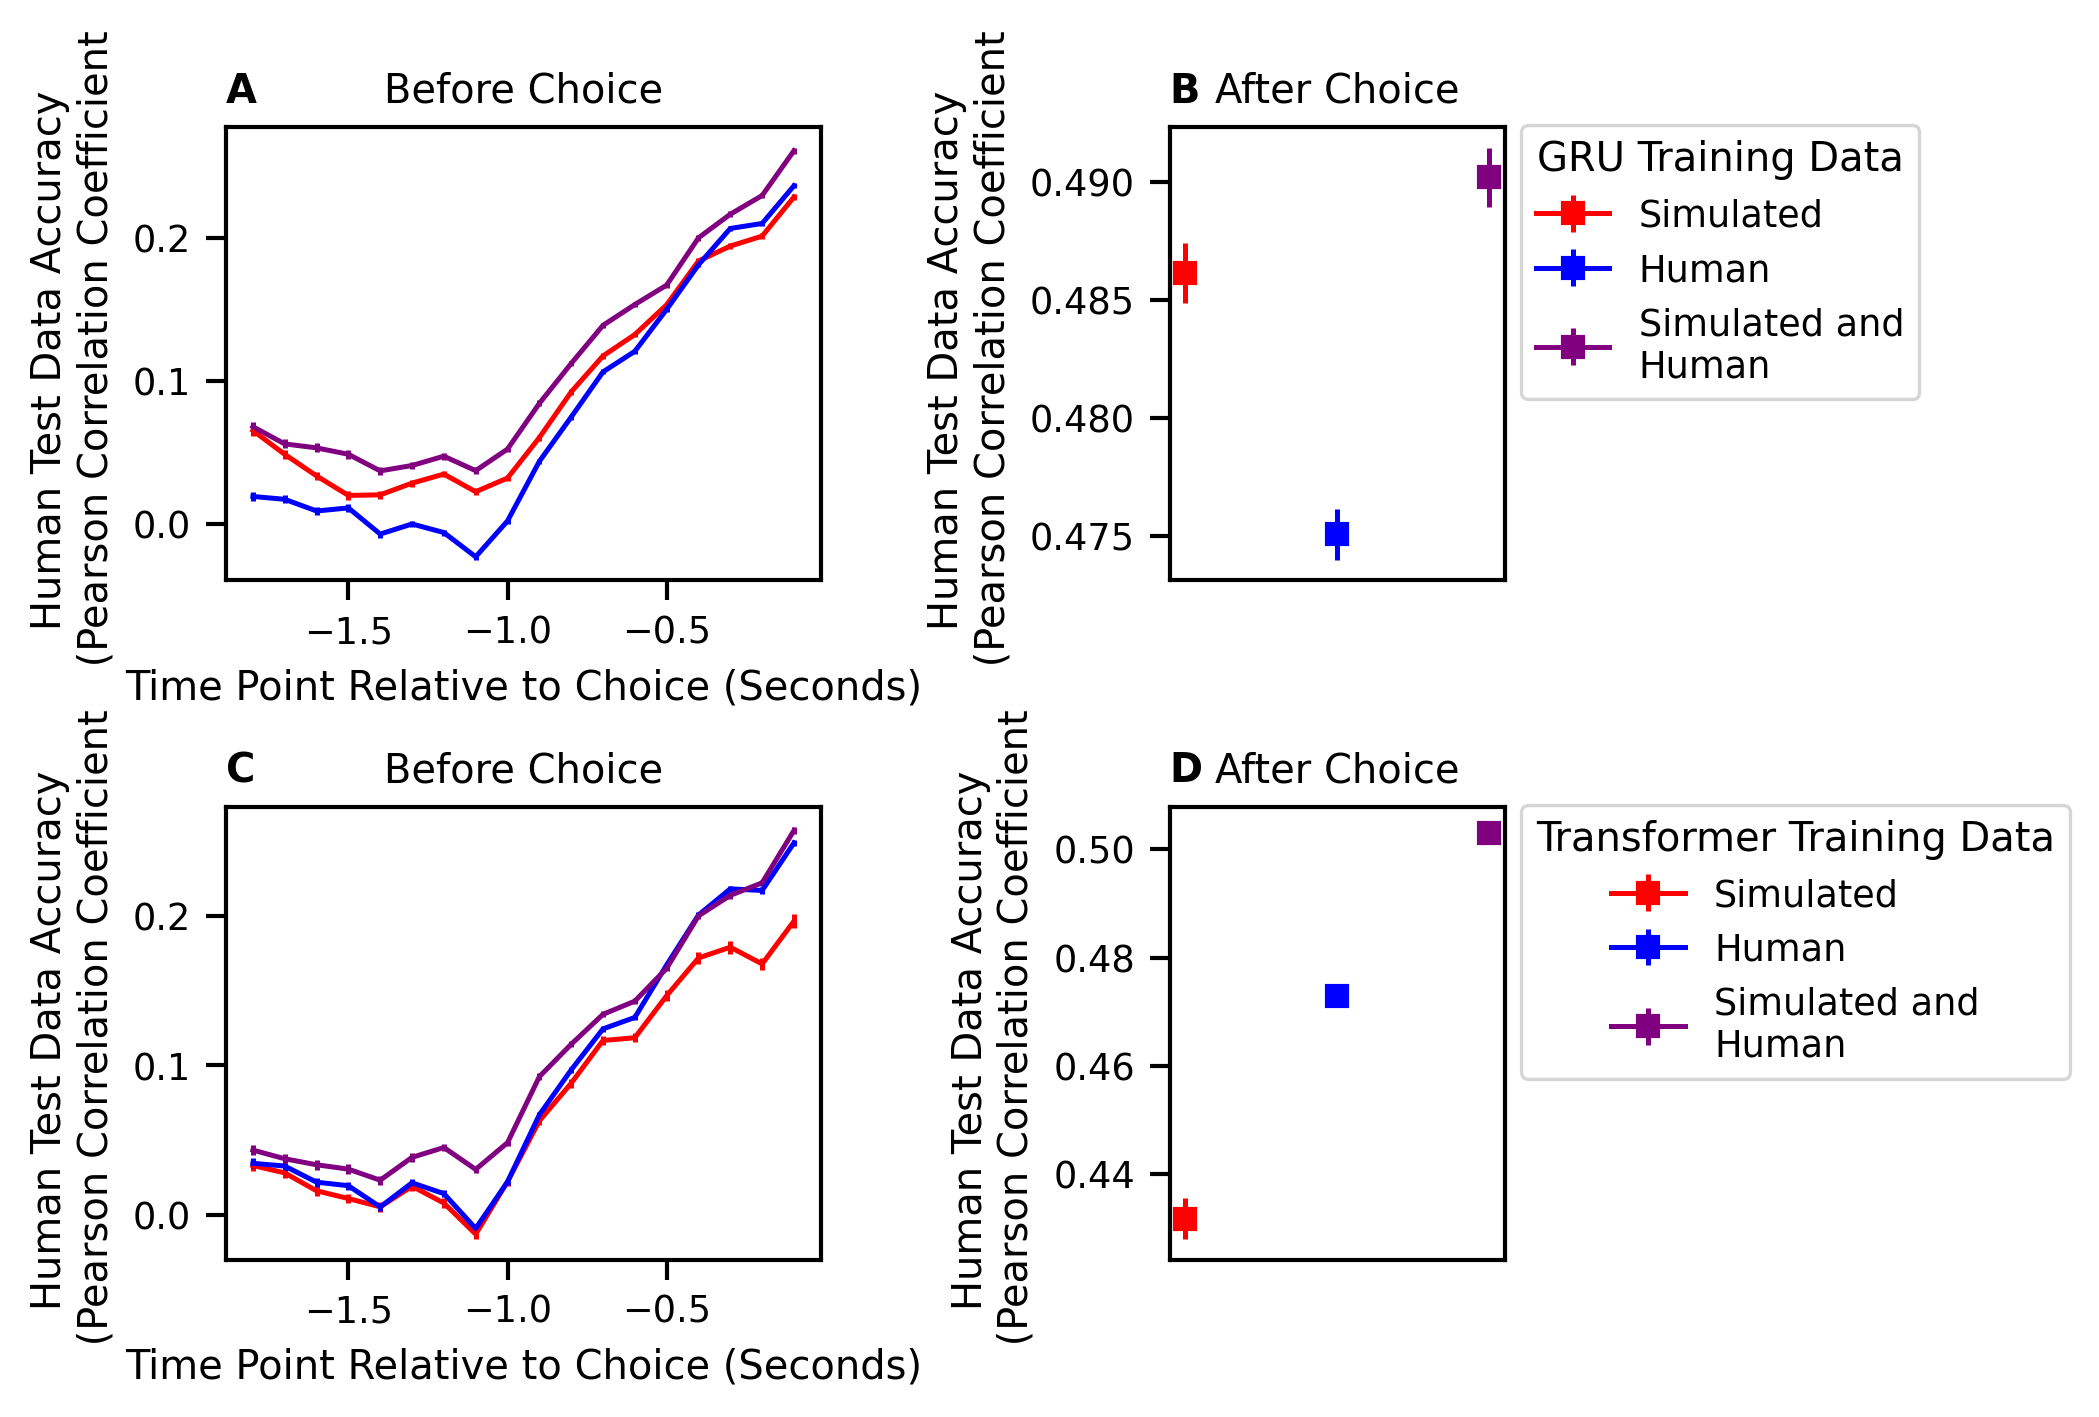

In [10]:
sns.set_context("paper")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 5), dpi = 300,
                       gridspec_kw={
                        'width_ratios': [4, 2.25],
                       'wspace': .75,
                       'hspace': .5}, sharey = False)
plot_compare_traindata('GRU', [ax[0,0], ax[0,1]], labels = ['A', 'B'])
plot_compare_traindata('Transformer', [ax[1,0], ax[1,1]], labels = ['C', 'D'])

plt.savefig("Paper_Figs_F/Compare_Train_Data_Other.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("Paper_Figs_F/Compare_Train_Data_Other.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


#### plot all control models sim


Sim 

ID, mean r: 0.1106580549920851
sum, mean r: 0.2663855240285677
prop, mean r: 0.23309741999578823
all, mean r: 0.2790475636645014
Human 

ID, mean r: 0.09476157548835502
sum, mean r: 0.08819425164841574
prop, mean r: 0.10197542621795527
all, mean r: 0.10462208047382768


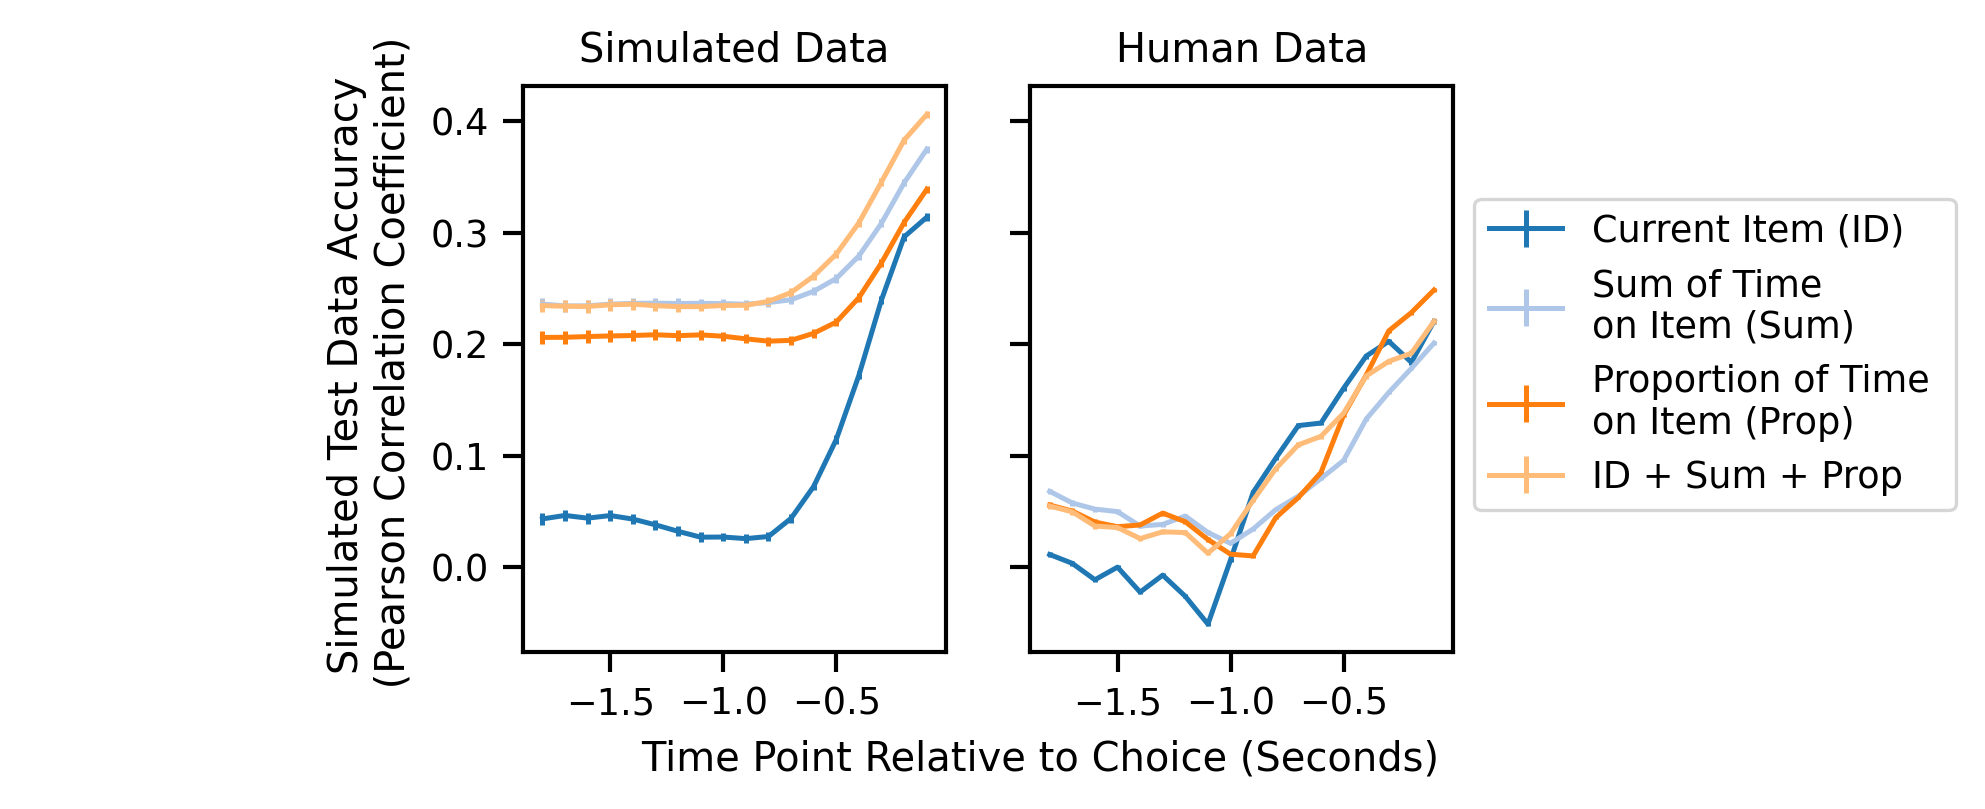

In [11]:
"""
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.5), dpi = 300,
                       gridspec_kw={
                        'width_ratios': [4, 2.25],
                       'wspace': .75,
                       'hspace': .5}, sharey = False)
"""



def plot_control_models(part_name, test_human , ax, control_fus = ['ID', 'sum', 'prop', 'all'], include_ylabel = True):

    colors = plt.cm.tab20(range(5))

    if test_human:
        which_res = 'r_human_by_n_back'
        ylabel = 'Human Test Data Accuracy \n (Pearson Correlation Coefficient)'
    else:
        which_res = 'r_sim_by_n_back'
        ylabel = 'Simulated Test Data Accuracy \n (Pearson Correlation Coefficient)'

    fu_names = ['Current Item (ID)', 'Sum of Time \non Item (Sum)', 'Proportion of Time \non Item (Prop)', 'ID + Sum + Prop']

    these_tps = np.arange(-18,0,1)/10
    # do the fix_only model...

    r_fix_control_all_runs = {}
    for fu_idx, fu in enumerate(control_fus):

        r_fix_control_all_runs[fu] = get_res_fixations_all_runs(fu, '', '', part_name, n_runs = 200, an_part = 'control', which_res = which_res)

        mn_r_by_n_back_c, sem_r_c = get_mn_results(fu, '', '', part_name, n_runs = 200, an_part = 'control', which_res = which_res)
        ax.errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = fu_names[fu_idx], color = colors[fu_idx])

    # ax.set_xlabel('Time Point Relative to Choice (Seconds)')
    if include_ylabel:
        ax.set_ylabel(ylabel)
    
    # mean_fus = [np.mean(r_fix_control_all_runs[fu]) for fu in control_fus]
    if test_human:
        print('Human \n')
    else:
        print('Sim \n')
    for fu in control_fus:
        print('{}, mean r: {}'.format(fu, np.mean(r_fix_control_all_runs[fu])))
    
    
#mean_fus = [np.mean(r_fix_control_all_runs[fu]) for fu in control_fus]
#sem_fus = [1.96*np.std(r_fix_control_all_runs[fu])/np.sqrt(len(r_fix_control_all_runs[fu])) for fu in control_fus]
#ax[0].errorbar(control_fus, mean_fus, yerr = sem_fus, fmt='none')


# ax.legend(loc = (1.01,.25))

control_fus = ['ID', 'sum', 'prop', 'all']
part_name = 'Simulated_and_Human'
test_human = True

fig,ax = plt.subplots(1,2, figsize = (4,2.5), dpi = 300, sharex = False, sharey = True)
plot_control_models('Simulated_Only', False , ax[0], control_fus = ['ID', 'sum', 'prop', 'all'])
plot_control_models('Simulated_and_Human', True , ax[1], control_fus = ['ID', 'sum', 'prop', 'all'], include_ylabel = False)
ax[0].set_title('Simulated Data')
ax[1].set_title('Human Data')
# fig.supxlabel('Year')

ax[0].set_xlabel('                                                Time Point Relative to Choice (Seconds)');
ax[1].legend(loc = (1.05, .25))

# fig.supxlabel('Time Point Relative to Choice')
plt.savefig("Paper_Figs_F/Compare_Control.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("Paper_Figs_F/Compare_Control.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)
